<img src ="Images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Interpolation with anisotropy
#### Gator Glaciology Lab, University of Florida

Geologic phenomena often have a directional component. Here, we demonstrate how to implement kriging and SGS with anisotropy.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import QuantileTransformer 
import skgstat as skg
from skgstat import models
import GStatSim as gs
import earthpy.spatial as es

## Load and plot data

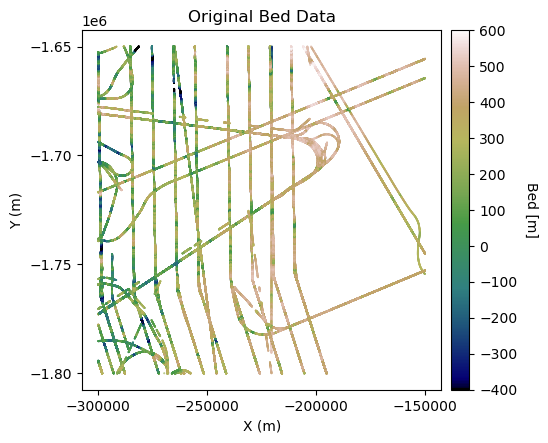

In [5]:
df_bed = pd.read_csv('Data/greenland_test_data.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed["Bed"] <= 700]  

# plot original data
plt.figure(figsize=(5,5))
im = plt.scatter(df_bed['X'], df_bed['Y'], c=df_bed['Bed'], vmin=-400, vmax=600, 
                 marker='.', s=0.5, cmap='gist_earth')
plt.title('Original Bed Data')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.locator_params(nbins=5)

# make colorbar
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label('Bed [m]', rotation=270, labelpad=15)

ax.axis('scaled')
plt.show()

## Grid and transform data. Get variogram parameters

See variogram tutorials for details

In [6]:
# grid data to 100 m resolution and remove coordinates with NaNs
res = 1000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000                                               # maximum range distance
n_lags = 70                                                  # num of bins

V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'

# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

## Simple kriging with anisotropy

Here we will implement simple kriging with anisotropy by adding 15 km to the the major range (a_maj). We chose an exaggerated range anisotropy for visualization purposes. However, the major and minor ranges would normally be determined by examining the variogram at different orientations.

In [7]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0] + 15000
minor_range = V1.parameters[0]
sill = V1.parameters[1] 
vario = [azimuth, nugget, major_range, minor_range, sill]

k = 100                     # number of neighboring data points used to estimate a given point 
rad = 50000                 # 50 km search radius

# est_SK is the estimate and var_SK is the variance
est_SK, var_SK = gs.Interpolation.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 

100%|████████████████████████████████████| 22500/22500 [02:17<00:00, 163.34it/s]


In [8]:
# reverse normal score transformation
est_SK = est_SK.reshape(-1,1)
spred_trans = nst_trans.inverse_transform(est_SK)

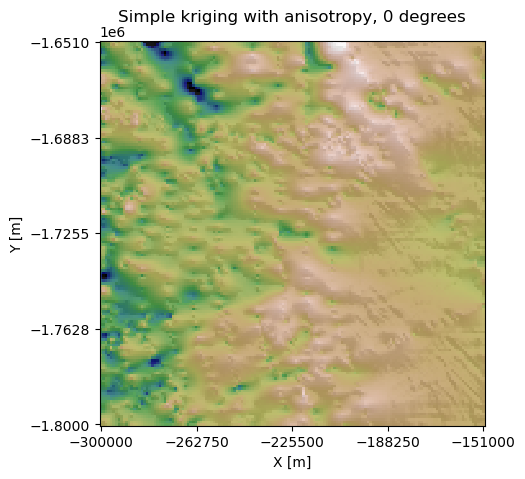

In [13]:
# make hillshade plot for visualizing
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))
spred_trans_mat = spred_trans.reshape((rows, cols))

hillshade = es.hillshade(spred_trans_mat, azimuth = 210, altitude = 10)

plt.figure(figsize=(5,5))
plt.pcolormesh(x_mat, y_mat, spred_trans_mat, vmin=-400, vmax=600, cmap='gist_earth')
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='Greys', alpha=0.1)
plt.title('Simple kriging with anisotropy, 0 degrees', pad=14)
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))
plt.axis('scaled')
plt.show()

In the above example, we used an Azimuth of 0, so the topography is stretched along the horizontal axis. Let's try changing the Azimuth to 60 degrees:

In [14]:
azimuth = 60
vario2 = [azimuth, nugget, major_range, minor_range, sill]

est_SK_60, var_SK = gs.Interpolation.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario2, rad) 

# reverse normal score transformation
est_SK_60 = est_SK_60.reshape(-1,1)
spred_trans = nst_trans.inverse_transform(est_SK_60)

100%|████████████████████████████████████| 22500/22500 [02:24<00:00, 155.36it/s]


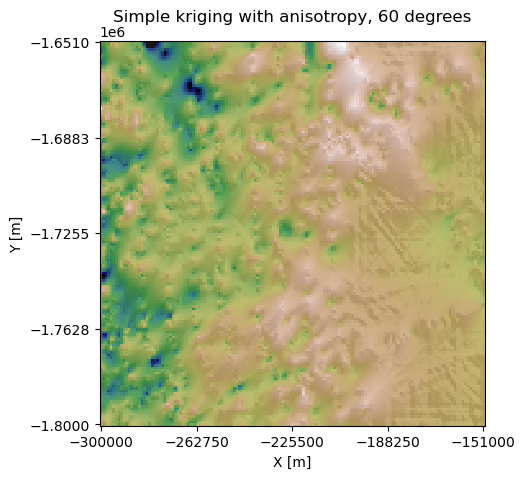

In [15]:
spred_trans_mat = spred_trans.reshape((rows, cols))

hillshade = es.hillshade(spred_trans_mat, azimuth = 210, altitude = 10)

plt.figure(figsize=(5,5))
plt.pcolormesh(x_mat, y_mat, spred_trans_mat, vmin=-400, vmax=600, cmap='gist_earth')
plt.pcolormesh(x_mat, y_mat, hillshade, cmap='Greys', alpha=0.1)
plt.title('Simple kriging with anisotropy, 60 degrees', pad=14)
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.xticks(np.linspace(xmin, xmax, 5))
plt.yticks(np.linspace(ymin, ymax, 5))
plt.axis('scaled')
plt.show()

## SGS with anisotropy

The same approach can be used to implement SGS with anisotropy:

In [16]:
# horizontal orientation
sim = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad)
sim = sim.reshape(-1,1)
sim_trans = nst_trans.inverse_transform(sim)

# 60 degree orientation
sim60 = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario2, rad)
sim60 = sim60.reshape(-1,1)
sim60_trans = nst_trans.inverse_transform(sim60)

100%|████████████████████████████████████| 22500/22500 [02:55<00:00, 128.24it/s]


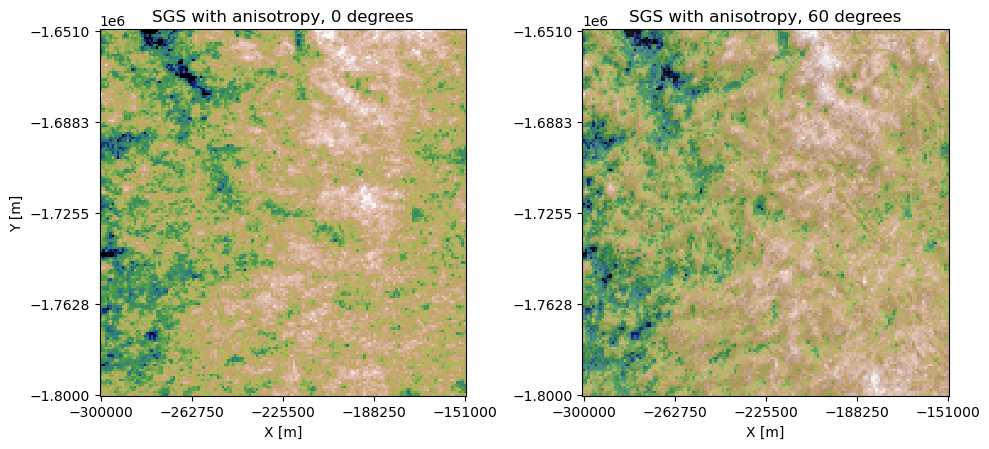

In [21]:
plots = [sim_trans, sim60_trans]
degrees = [0, 60]

fig, axs = plt.subplots(1, 2, figsize=(10,5))

for i, (ax, plot) in enumerate(zip(axs, plots)):
    sgs_mat = plot.reshape((rows, cols))
    hillshade = es.hillshade(spred_trans_mat, azimuth = 210, altitude = 10)
    im = ax.pcolormesh(x_mat, y_mat, sgs_mat, vmin=-400, vmax=600, cmap='gist_earth')
    plt.pcolormesh(x_mat, y_mat, hillshade, cmap='Greys', alpha=0.1)
    ax.set_title(f'SGS with anisotropy, {degrees[i]} degrees')
    ax.set_xlabel('X [m]')
    if i == 0:
        ax.set_ylabel('Y [m]')
    ax.set_xticks(np.linspace(xmin, xmax, 5))
    ax.set_yticks(np.linspace(ymin, ymax, 5))
    ax.axis('scaled')

plt.tight_layout()
plt.show()